# 1. Data Exploration & Preprocessing

In [12]:
# Step 1: Import the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Step 2: Load the dataset
# Update the path as needed; if using Google Colab, you can mount your drive and set the path accordingly.
df = pd.read_csv(r'C:/Users/ABC/Downloads/Customer_data - customer_data.csv')  # or simply 'Customer_data.csv' if uploaded directly

# Step 3: Explore the dataset
print("First five rows:")
print(df.head())

print("\nDataset Info:")
print(df.info())

print("\nStatistical Summary:")
print(df.describe())

# Step 4: Check for missing values
print("\nMissing values per column:")
print(df.isnull().sum())

# Example: Convert 'TotalCharges' to numeric (if it is read as a string) and handle any missing values
if 'TotalCharges' in df.columns:
    df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
    # Fill missing TotalCharges values with the mean value of the column
    df['TotalCharges'] = df['TotalCharges'].fillna(df['TotalCharges'].mean())

# Step 5: Preprocess target variable and categorical features
# Convert the target 'Churn' from Yes/No to 1/0
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})

# Identify categorical features (based on the provided Data Dictionary)
categorical_features = [
    'gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 
    'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
    'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
    'PaperlessBilling', 'PaymentMethod'
]

# Use one-hot encoding for categorical variables; drop the first to avoid dummy variable trap.
df = pd.get_dummies(df, columns=categorical_features, drop_first=True)

# Optionally, remove any non-predictive columns (like customerID) if present.
if 'customerID' in df.columns:
    df.drop('customerID', axis=1, inplace=True)

# Confirm preprocessing by viewing the updated dataframe structure
print("\nData after preprocessing:")
print(df.head())


First five rows:
   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...               No   

  TechSupport StreamingTV StreamingMovies    

# 2. Model Development

In [13]:
# Step 1: Import the scikit-learn model and splitting utilities
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

# Step 2: Split the data into features (X) and target (y)
X = df.drop('Churn', axis=1)
y = df['Churn']

# Divide the dataset into 80% training and 20% testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 3: Initialize and train the Random Forest model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)



RandomForestClassifier(random_state=42)

In [14]:
from sklearn.model_selection import GridSearchCV

# Define a grid of hyperparameters
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}

# Initialize GridSearchCV with the Random Forest model
grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, 
                           cv=5, scoring='f1', n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Best hyperparameters: ", grid_search.best_params_)

# Use the best estimator for further predictions and evaluations
model = grid_search.best_estimator_


Best hyperparameters:  {'max_depth': None, 'min_samples_split': 10, 'n_estimators': 100}


# Step 3: Model Evaluation

Evaluation Metrics:
Accuracy: 0.8126
Precision: 0.6982
Recall: 0.5147
F1 Score: 0.5926
ROC AUC Score: 0.8586


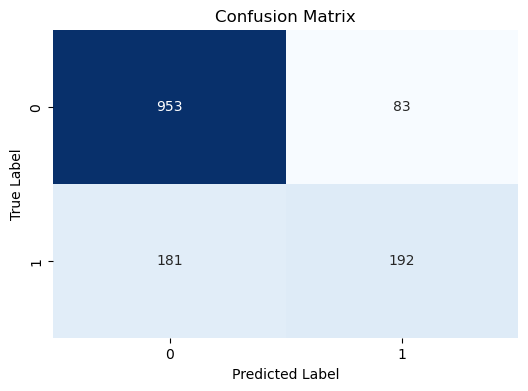

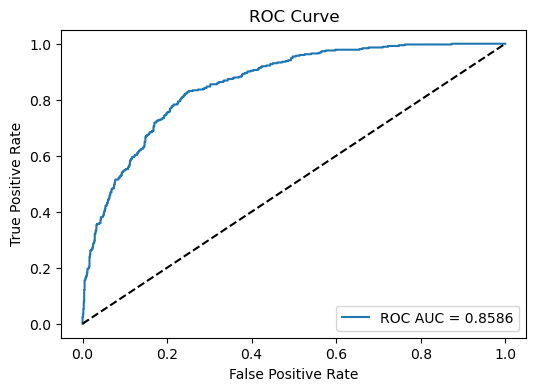

In [15]:
# Import evaluation libraries
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

# best_params = {'max_depth': None, 'min_samples_split': 10, 'n_estimators': 100}

from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(max_depth=None, min_samples_split=10, n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]  # probability estimates for the positive (churn) class

# Compute evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print("Evaluation Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC Score: {roc_auc:.4f}")

# Plot the confusion matrix
conf_mat = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Optional: Plot the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"ROC AUC = {roc_auc:.4f}")
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line representing random chance
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()


# Final presentation 

Link :-  https://drive.google.com/file/d/1UavxYRh845UeFflrMeOUNH8XUIe1fR_n/view?usp=sharing